In [21]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import warnings
import itertools

warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
pd.set_option('display.max_columns', None)

ckd_df = pd.read_excel(
    "Data/ckd_dataset.xlsx",
    usecols = "B:D,F:Y,AL:AQ,AS:AY"
)

ckd_df

,gender,age,SBP,etiology of CKD,Hb,Alb,Cr,eGFR,CKD_stage,CKD category,dip-stick proteinuria,proteinuria,urinary occult blood,UPCR,UPCR category,hypertension,prevalence of CVD,diabetes,use of RAASi,use of CCB,use of diuretics,eGFR(0M),50%eGFR,eGFR(last visit),observational duration,50%eGFR_reached,50%eGFR_duration,RRT,RRT_duration,CKD progression,CKD progression_duration,death,death_duration,development of CVD,development of CVD_duration,≥6M followed
0,2,74,120.0,2,12.0,4.0,1.20,34.146986,3,6.0,2.0,1.0,0.0,1.253731,3.0,1,0,0,1,1,0,34.146986,17.073493,18.495328,37,0,37,0,37,0,37,0,37,0,37,1
1,1,39,121.0,3,15.0,4.7,1.31,50.451187,3,5.0,0.0,0.0,0.0,0.325926,2.0,1,0,0,0,0,0,50.451187,25.225594,50.451187,1,0,1,0,1,0,1,0,1,0,1,0
2,1,74,143.0,2,10.9,3.8,4.95,9.804696,5,12.0,3.0,1.0,0.0,1.759615,3.0,1,0,1,1,1,1,9.804696,4.902348,5.578057,13,0,13,1,13,1,13,0,13,0,13,1
3,1,57,139.0,2,15.9,4.8,0.84,73.570568,2,4.0,1.0,1.0,0.0,0.513514,3.0,1,0,0,0,0,0,73.570568,36.785284,67.225032,37,0,37,0,37,0,37,0,37,0,37,1
4,1,32,154.0,4,14.4,4.4,0.87,83.558305,2,1.0,-1.0,0.0,0.0,0.025000,1.0,1,0,0,0,0,0,83.558305,41.779153,69.171408,36,0,36,0,36,0,36,0,36,0,36,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,2,71,179.0,2,9.9,4.2,1.90,20.901554,4,9.0,1.0,1.0,1.0,0.651558,3.0,1,0,0,0,0,0,20.901554,10.450777,20.901554,1,0,1,0,1,0,1,0,1,0,1,0
1134,2,62,139.0,1,11.8,4.0,4.74,7.993339,5,12.0,2.0,1.0,1.0,2.784223,3.0,1,1,1,1,1,0,7.993339,3.996670,4.664378,36,0,36,0,36,0,36,0,36,0,36,1
1135,1,60,118.0,2,14.6,4.2,1.42,40.819612,3,4.0,-1.0,0.0,0.0,0.020450,1.0,1,0,0,1,1,0,40.819612,20.409806,41.861876,38,0,38,0,38,0,38,0,38,0,38,1
1136,1,52,94.0,4,13.5,4.3,2.13,27.293642,4,8.0,-1.0,0.0,0.0,0.260047,2.0,1,0,0,1,0,0,27.293642,13.646821,28.931595,36,0,36,0,36,0,36,0,36,0,36,1


In [22]:
#filtering

ckd_df.dropna(inplace=True)
eGFR_final_mean = ckd_df["eGFR(last visit)"].mean()
eGFR_final_std = ckd_df["eGFR(last visit)"].std()
filtered_ckd_df = ckd_df[(ckd_df["eGFR(last visit)"] < (eGFR_final_mean + 3*eGFR_final_std)) & (ckd_df["eGFR(last visit)"] < (.95 * ckd_df["eGFR"]))]
# filtered_ckd_df = ckd_df[(ckd_df["CKD progression"] == 1)]
filtered_ckd_df

,gender,age,SBP,etiology of CKD,Hb,Alb,Cr,eGFR,CKD_stage,CKD category,dip-stick proteinuria,proteinuria,urinary occult blood,UPCR,UPCR category,hypertension,prevalence of CVD,diabetes,use of RAASi,use of CCB,use of diuretics,eGFR(0M),50%eGFR,eGFR(last visit),observational duration,50%eGFR_reached,50%eGFR_duration,RRT,RRT_duration,CKD progression,CKD progression_duration,death,death_duration,development of CVD,development of CVD_duration,≥6M followed
0,2,74,120.0,2,12.0,4.0,1.20,34.146986,3,6.0,2.0,1.0,0.0,1.253731,3.0,1,0,0,1,1,0,34.146986,17.073493,18.495328,37,0,37,0,37,0,37,0,37,0,37,1
2,1,74,143.0,2,10.9,3.8,4.95,9.804696,5,12.0,3.0,1.0,0.0,1.759615,3.0,1,0,1,1,1,1,9.804696,4.902348,5.578057,13,0,13,1,13,1,13,0,13,0,13,1
3,1,57,139.0,2,15.9,4.8,0.84,73.570568,2,4.0,1.0,1.0,0.0,0.513514,3.0,1,0,0,0,0,0,73.570568,36.785284,67.225032,37,0,37,0,37,0,37,0,37,0,37,1
4,1,32,154.0,4,14.4,4.4,0.87,83.558305,2,1.0,-1.0,0.0,0.0,0.025000,1.0,1,0,0,0,0,0,83.558305,41.779153,69.171408,36,0,36,0,36,0,36,0,36,0,36,1
6,1,49,135.0,2,17.0,4.1,1.39,44.285063,3,6.0,3.0,1.0,0.0,3.947368,3.0,1,1,0,0,1,0,44.285063,22.142531,38.106104,30,0,30,0,30,0,30,0,30,0,30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,1,75,120.0,1,11.2,3.9,2.56,20.092993,4,8.0,-1.0,0.0,0.0,0.210210,2.0,1,0,1,1,1,0,20.092993,10.046496,15.511510,37,0,37,0,37,0,37,0,37,0,37,1
1128,2,72,169.0,1,6.6,2.7,3.12,12.100035,5,12.0,3.0,1.0,0.0,17.298091,3.0,1,0,1,0,1,0,12.100035,6.050017,9.285258,7,0,7,1,10,1,10,0,10,0,7,1
1131,1,71,154.0,2,15.4,4.2,1.08,52.471683,3,6.0,2.0,1.0,0.0,0.760234,3.0,1,0,0,1,0,0,52.471683,26.235842,47.952934,38,0,38,0,38,0,38,0,38,0,38,1
1132,1,81,154.0,2,9.0,3.5,2.00,25.747776,4,9.0,2.0,1.0,0.0,1.038526,3.0,1,1,0,1,1,1,25.747776,12.873888,17.923736,37,0,37,0,37,0,37,0,37,0,37,1


-0.6696646213531494

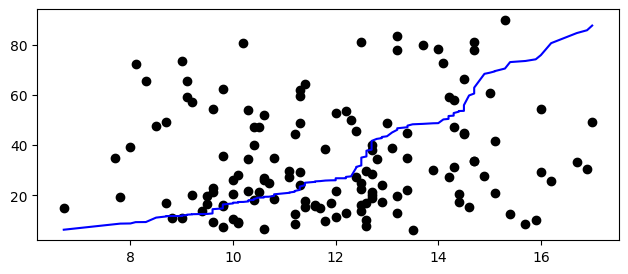

In [57]:
#linear regression with xgboosting 
#this really sucks right now

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb

features = filtered_ckd_df.loc[:, ["Hb", "Alb", "Cr", "CKD_stage", "UPCR", "proteinuria"]]
target = filtered_ckd_df.loc[:, ["eGFR"]]

reg_X_train, reg_X_test,  reg_Y_train, reg_Y_test = train_test_split(features, target, test_size=0.25, random_state = 22)
reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(reg_X_train, reg_Y_train)

reg_Y_pred = reg.predict(reg_X_test)
reg_X_test.sort_values(by=["Hb"], inplace=True)
reg_Y_pred = np.sort(reg_Y_pred, axis=0)

fig, ax = plt.subplots(figsize=(7.5,3))
ax.scatter(reg_X_test.iloc[:, 0], reg_Y_test, color = "black")
ax.plot(reg_X_test.iloc[:, 0], reg_Y_pred, color = "blue")

r2_score = r2_score(reg_Y_test, reg_Y_pred)
r2_score

In [ ]:
#classification